In [1]:
import torch
from torch import nn

import numpy as np

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Operator
from qiskit.visualization import plot_histogram

from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeAthensV2

import pennylane as qml

import matplotlib.pyplot as plt

from random import shuffle
from tqdm import tqdm

In [2]:
import sys
sys.path.append('../')

In [3]:
from circuits.generate_circuits import custom_ghz
from circuits.modify_circuits import append_pqc_to_quantum_circuit, get_circuit_for_model, get_unitary_for_model_pennylane
from circuits.pqc_circuits import pennylane_PQC_RZRXRZ_unique, qiskit_PQC_RZRXRZ_unique, qiskit_PQC_RXRZ_unique

from simulator.simulate import get_ideal_data_state, get_ideal_data_superpos
from models.pennylane_models import SimplePennylaneQuantumStateModel
from models.noise_models import BitPhaseFlipNoise
from circuits.generate_circuits import GetGHZCircuitsForModel
from utils.loss_functions import QuantumFidelityLoss

In [4]:
if torch.mps.is_available():
    print('Torch running on Apple GPU')
    torch_device = torch.device("mps")
    aer_device = "CPU"
elif torch.cuda.is_available():
    print('Torch running on Nvidia GPU')
    torch_device = torch.device("cuda")
    aer_device = "GPU"
else:
    print('Torch running on CPU')
    torch_device = torch.device("cpu")
    aer_device = "CPU"


Torch running on Nvidia GPU


In [5]:
NUM_SHOTS = 2**10
NUM_QUBITS = 5
H_ON = 3
INPUT_BITS = '10101'
EPOCHS = 5
# fakeVigo2_backend = FakeVigoV2()
# fakeAthensV2_backend = FakeAthensV2()

ideal_sim = AerSimulator()
# noisy_sim = AerSimulator().from_backend(fakeAthensV2_backend)
pqc_arch = pennylane_PQC_RZRXRZ_unique

In [6]:
noise_model = BitPhaseFlipNoise()

pqc_model = SimplePennylaneQuantumStateModel(
    num_qubits= NUM_QUBITS, num_params=NUM_QUBITS*3, pqc_arch_func=pqc_arch,   
    )

ghz_circuit_gen = GetGHZCircuitsForModel(
    num_qubits= NUM_QUBITS, hammard_on=H_ON, noise=noise_model
    )



In [7]:
optimizer = torch.optim.AdamW(pqc_model.parameters(), lr=0.05)
loss_fn = QuantumFidelityLoss()
# loss_fn = nn.MSELoss()

In [8]:
ideal_data = get_ideal_data_state(NUM_QUBITS, num_vals=int(10000))
# get_ideal_data(NUM_QUBITS, NUM_SHOTS, num_values=1000, get_soft=False)
print(len(ideal_data[10][1]))

Generating Ideal Data: 100%|██████████| 10000/10000 [00:10<00:00, 986.18it/s]

32


In [9]:
param_list_epoch = []  # Stores parameter evolution across epochs
loss_list_epoch = []   # Stores mean loss per epoch

enable_debug_logs = True  # Set False to suppress grad/param printouts
lambda_reg = 0.01         # Regularization weight

for epoch in range(EPOCHS):
    print(f'\n Starting Epoch {epoch+1}')
    pqc_model.train()
    epoch_loss_list = []
    epoch_param_snapshots = []

    shuffle(ideal_data)
    data_iterator = tqdm(ideal_data)

    for step, (params, ideal) in enumerate(data_iterator):
        optimizer.zero_grad()

        circuit = ghz_circuit_gen.get_noisy_model_circuit_params(params)
        measured = pqc_model(circuit=circuit)

        ideal = ideal.to(torch_device)
        measured = measured.to(torch_device)

        # print(ideal)
        # print(measured)

        # Compute fidelity loss
        # print(ideal)
        # print(measured)
        loss = loss_fn(ideal, measured)

        # Add optional regularization to keep angles from zeroing out

        loss.backward()
        optimizer.step()

        raw_param_values = pqc_model.raw_params.detach().cpu().numpy()
        epoch_param_snapshots.append(raw_param_values)
        epoch_loss_list.append(loss.item())

        data_iterator.set_postfix_str(f"Loss: {loss.item():.4e}")

        # Optional: print debug stats
        if enable_debug_logs and step == 0:
            grad_norm = pqc_model.raw_params.grad.norm().item()
            # bounded = pqc_model.raw_params.detach().cpu().numpy()
            print(f"\tStep {step}, grad norm: {grad_norm:.4e}")
            print(f"\tRaw param range: [{raw_param_values.min():.3f}, {raw_param_values.max():.3f}]")
            # print(f"\tBounded param range: [{bounded.min():.3f}, {bounded.max():.3f}]")

# Optional: print debug stats
        # if enable_debug_logs and step == len(data_iterator) - 1:
        #     print(circuit.draw())
        #     print(measured)
        #     print(ideal)
        #     print(loss)

    # Log epoch summary
    avg_loss = np.mean(epoch_loss_list)
    loss_list_epoch.append(avg_loss)
    param_list_epoch.extend(np.array(epoch_param_snapshots))

    print(f"Epoch {epoch+1} complete: avg loss = {avg_loss:.4e}")

        


 Starting Epoch 1


  0%|          | 11/10000 [00:00<05:54, 28.14it/s, Loss: 8.4526e-01] 

	Step 0, grad norm: 1.1287e-02
	Raw param range: [-15.727, 9.953]


100%|██████████| 10000/10000 [02:45<00:00, 60.51it/s, Loss: 5.7515e-02]


     ┌─────────────┐ ┌────────────┐                                          »
q_0: ┤ Rx(0.16647) ├─┤ Rz(3.6298) ├──────────────────────────────────────────»
     └┬────────────┤┌┴────────────┤                                          »
q_1: ─┤ Rx(5.6504) ├┤ Rz(0.15952) ├──────────────────────────────────────────»
     ┌┴────────────┤└┬────────────┤                                          »
q_2: ┤ Rx(0.53697) ├─┤ Rz(6.1102) ├──────────────────────────────────────────»
     └┬────────────┤┌┴────────────┤┌───┐┌────────────────┐┌─────────────────┐»
q_3: ─┤ Rx(4.5743) ├┤ Rz(0.63567) ├┤ H ├┤ z_noise(0.101) ├┤ x_noise(0.1047) ├»
      ├────────────┤└┬────────────┤└───┘└────────────────┘└─────────────────┘»
q_4: ─┤ Rx(4.8342) ├─┤ Rz(3.0738) ├──────────────────────────────────────────»
      └────────────┘ └────────────┘                                          »
«     ┌───┐┌──────────────────┐┌──────────────────┐                         »
«q_0: ┤ X ├┤ z_noise(0.10673) ├┤ x_noise(0.10115) ├──

  0%|          | 0/10000 [00:00<?, ?it/s, Loss: 5.1287e-02]

	Step 0, grad norm: 9.5272e-02
	Raw param range: [-15.959, 9.202]


100%|██████████| 10000/10000 [02:40<00:00, 62.29it/s, Loss: 2.5628e-02]


     ┌─────────────┐  ┌────────────┐                         »
q_0: ┤ Rx(0.04427) ├──┤ Rz(1.0824) ├─────────────────────────»
     └┬────────────┤  ├────────────┤                         »
q_1: ─┤ Rx(2.9975) ├──┤ Rz(6.1498) ├─────────────────────────»
      ├────────────┤  ├────────────┤                         »
q_2: ─┤ Rx(3.7529) ├──┤ Rz(2.4564) ├─────────────────────────»
     ┌┴────────────┴┐┌┴────────────┤┌───┐┌──────────────────┐»
q_3: ┤ Rx(0.035261) ├┤ Rz(0.86559) ├┤ H ├┤ z_noise(0.10443) ├»
     └┬───────────┬─┘├─────────────┤└───┘└──────────────────┘»
q_4: ─┤ Rx(5.249) ├──┤ Rz(0.97906) ├─────────────────────────»
      └───────────┘  └─────────────┘                         »
«                         ┌───┐┌──────────────────┐┌──────────────────┐     »
«q_0: ────────────────────┤ X ├┤ z_noise(0.10048) ├┤ x_noise(0.10816) ├─────»
«                         └─┬─┘└──────────────────┘└──────────────────┘┌───┐»
«q_1: ──────────────────────┼──────────────────────────────────────────┤ 

  0%|          | 9/10000 [00:00<01:58, 84.38it/s, Loss: 8.7830e-02]

	Step 0, grad norm: 7.6730e-02
	Raw param range: [-15.910, 9.201]


100%|██████████| 10000/10000 [02:56<00:00, 56.82it/s, Loss: 4.3793e-02]


     ┌────────────┐┌────────────┐                                             »
q_0: ┤ Rx(3.7138) ├┤ Rz(5.4083) ├─────────────────────────────────────────────»
     ├────────────┤├────────────┤                                             »
q_1: ┤ Rx(5.8209) ├┤ Rz(5.3623) ├─────────────────────────────────────────────»
     ├────────────┤├────────────┤                                             »
q_2: ┤ Rx(6.1582) ├┤ Rz(2.7457) ├─────────────────────────────────────────────»
     ├────────────┤├───────────┬┘┌───┐┌──────────────────┐┌──────────────────┐»
q_3: ┤ Rx(1.2235) ├┤ Rz(3.619) ├─┤ H ├┤ z_noise(0.10234) ├┤ x_noise(0.10734) ├»
     ├────────────┤├───────────┴┐└───┘└──────────────────┘└──────────────────┘»
q_4: ┤ Rx(2.6682) ├┤ Rz(2.2512) ├─────────────────────────────────────────────»
     └────────────┘└────────────┘                                             »
«     ┌───┐┌─────────────────┐ ┌──────────────────┐                         »
«q_0: ┤ X ├┤ z_noise(0.1014) ├─┤ x_noise(0

  0%|          | 9/10000 [00:00<02:00, 83.10it/s, Loss: 4.1837e-02]

	Step 0, grad norm: 1.1308e-01
	Raw param range: [-15.909, 9.195]


100%|██████████| 10000/10000 [03:00<00:00, 55.54it/s, Loss: 2.5723e-02]


      ┌────────────┐ ┌────────────┐                                            »
q_0: ─┤ Rx(5.0473) ├─┤ Rz(4.1074) ├────────────────────────────────────────────»
      ├───────────┬┘ ├────────────┤                                            »
q_1: ─┤ Rx(5.645) ├──┤ Rz(2.2171) ├────────────────────────────────────────────»
     ┌┴───────────┴┐ ├────────────┤                                            »
q_2: ┤ Rx(0.17131) ├─┤ Rz(2.6893) ├────────────────────────────────────────────»
     └┬────────────┤ ├────────────┤┌───┐┌──────────────────┐┌─────────────────┐»
q_3: ─┤ Rx(1.5893) ├─┤ Rz(4.7358) ├┤ H ├┤ z_noise(0.10321) ├┤ x_noise(0.1066) ├»
      ├────────────┤┌┴────────────┤└───┘└──────────────────┘└─────────────────┘»
q_4: ─┤ Rx(5.3709) ├┤ Rz(0.93826) ├────────────────────────────────────────────»
      └────────────┘└─────────────┘                                            »
«     ┌───┐┌─────────────────┐ ┌──────────────────┐                         »
«q_0: ┤ X ├┤ z_noise(0.1092) ├─

  0%|          | 0/10000 [00:00<?, ?it/s, Loss: 4.5149e-02]

	Step 0, grad norm: 1.8184e-01
	Raw param range: [-15.893, 9.262]


100%|██████████| 10000/10000 [02:56<00:00, 56.55it/s, Loss: 5.0664e-02]

     ┌────────────┐┌────────────┐                                              »
q_0: ┤ Rx(5.6138) ├┤ Rz(3.2811) ├──────────────────────────────────────────────»
     ├────────────┤├────────────┤                                              »
q_1: ┤ Rx(6.0802) ├┤ Rz(2.9933) ├──────────────────────────────────────────────»
     ├────────────┤├────────────┤                                              »
q_2: ┤ Rx(1.1413) ├┤ Rz(5.6268) ├──────────────────────────────────────────────»
     ├────────────┤├────────────┤┌───┐┌──────────────────┐┌───────────────────┐»
q_3: ┤ Rx(3.7619) ├┤ Rz(6.0208) ├┤ H ├┤ z_noise(0.10913) ├┤ x_noise(0.099587) ├»
     ├────────────┤├───────────┬┘└───┘└──────────────────┘└───────────────────┘»
q_4: ┤ Rx(5.5029) ├┤ Rz(4.543) ├───────────────────────────────────────────────»
     └────────────┘└───────────┘                                               »
«     ┌───┐┌──────────────────┐┌──────────────────┐                         »
«q_0: ┤ X ├┤ z_noise(0.10951) ├

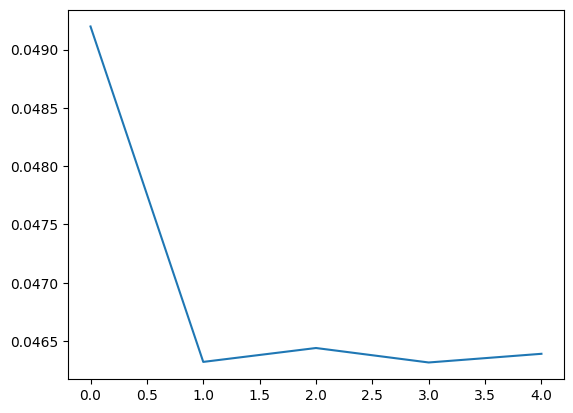

In [10]:
plt.plot(range(EPOCHS), loss_list_epoch)
plt.show()

In [11]:
print(pqc_model.raw_params)

Parameter containing:
tensor([  3.0848,   0.0710,   3.0315,   6.1807,  -0.1759,   0.0635,   0.0539,
         -6.5033,   6.1521, -15.9420,  -5.2398,   9.2544,   3.0081,  -6.0404,
         -3.1445], requires_grad=True)


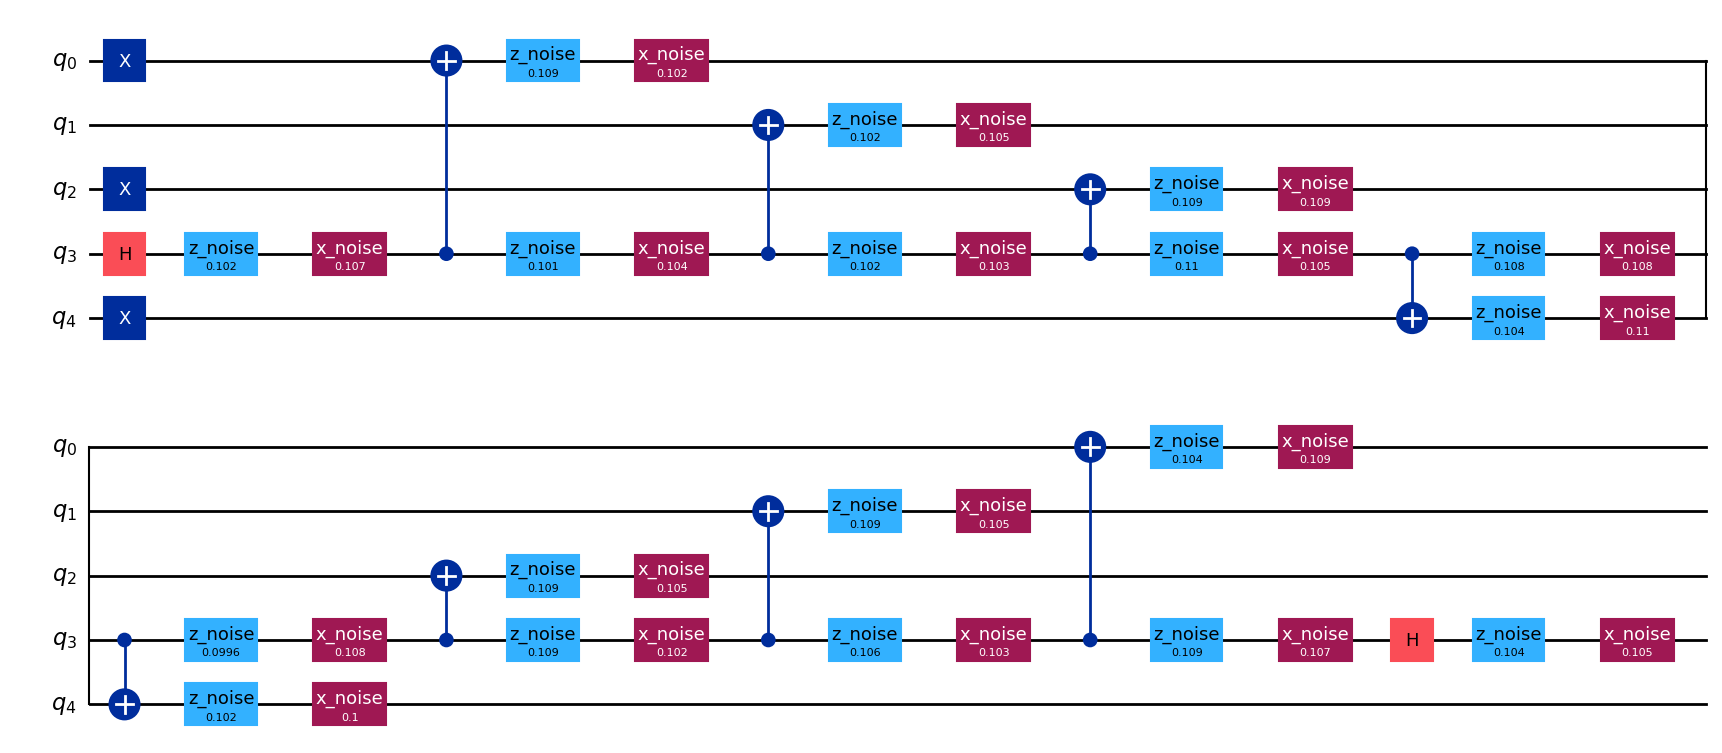

In [12]:
noisy_model_circ = ghz_circuit_gen.get_noisy_model_circuit_bitstring(INPUT_BITS)
noisy_model_circ.draw('mpl')

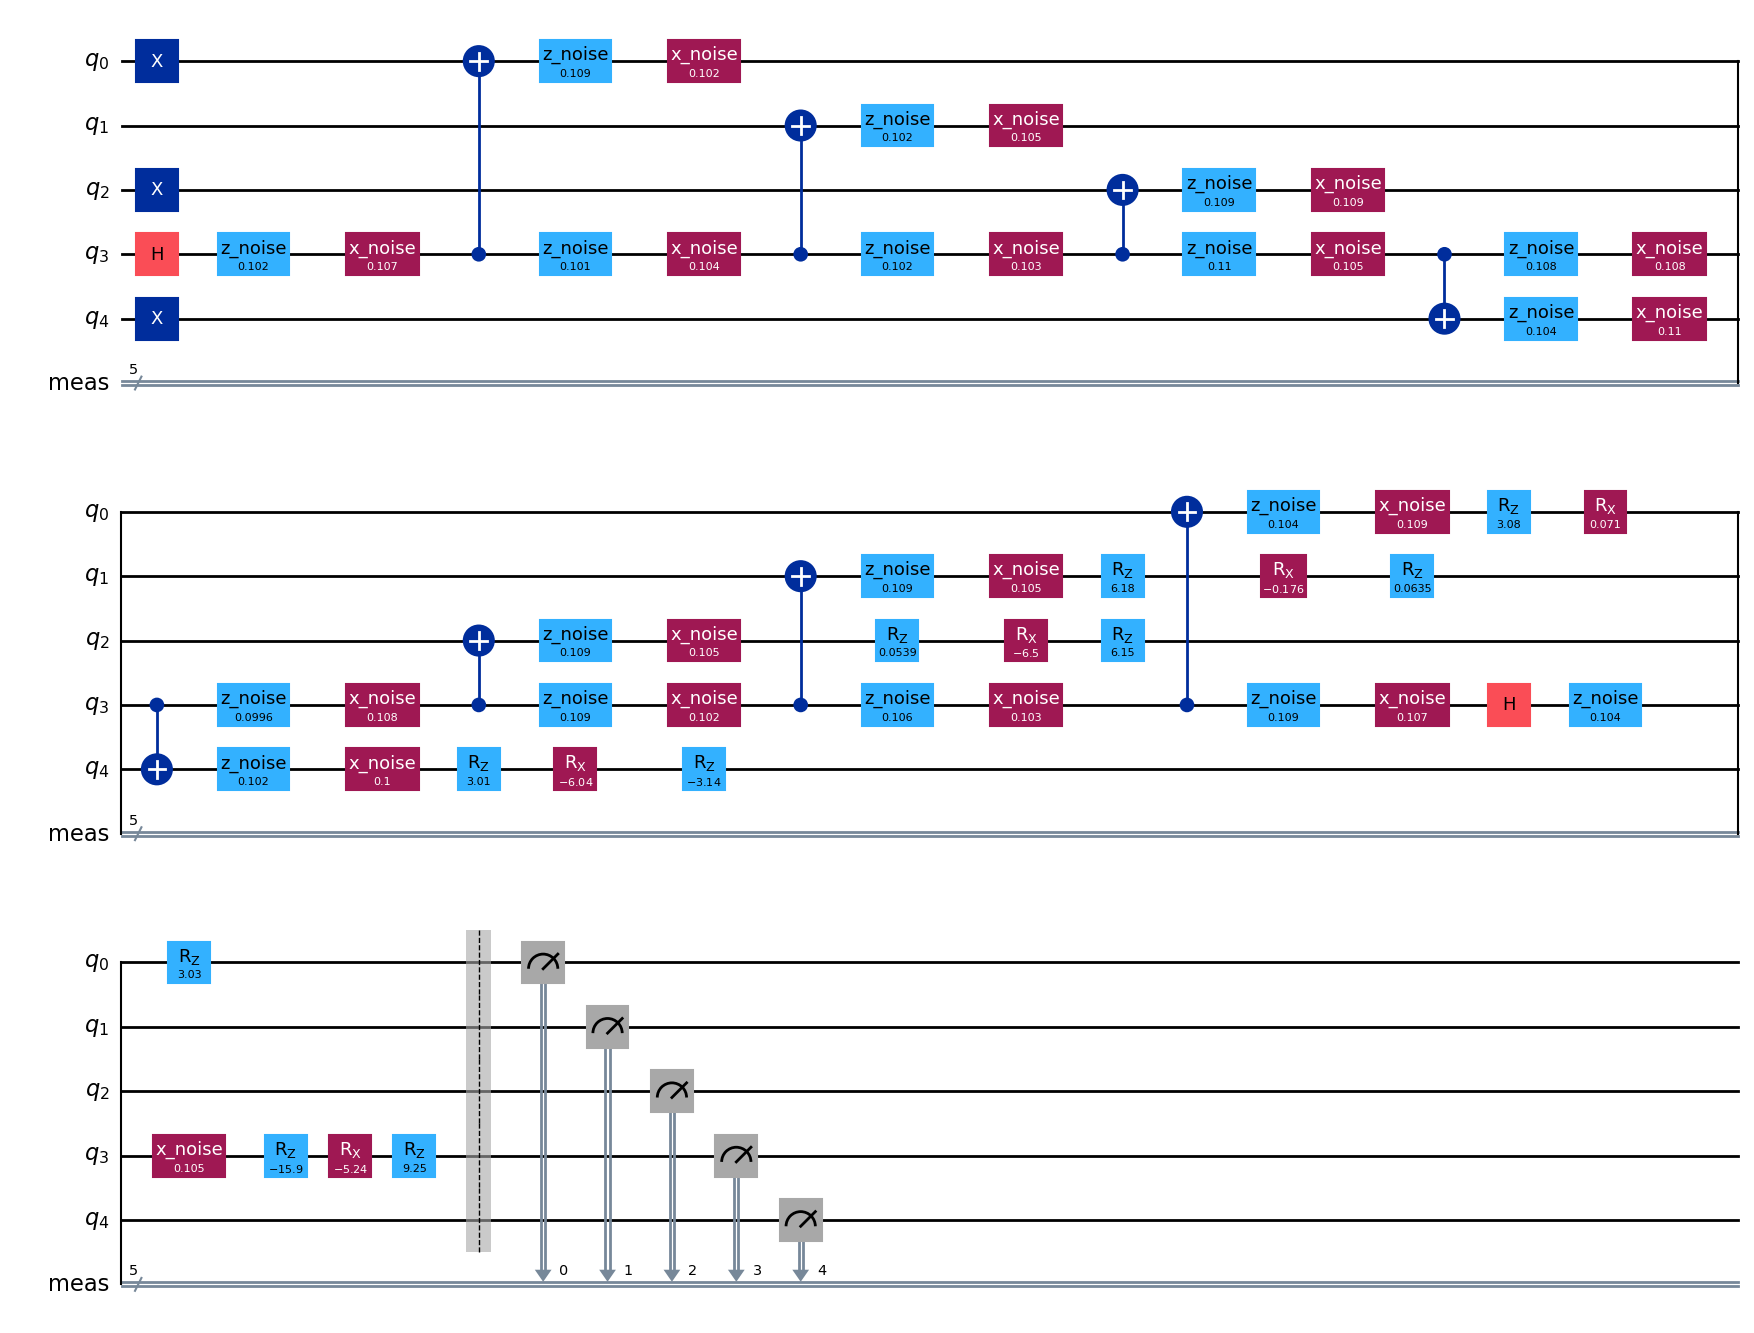

In [13]:
noisy_model_circ_pqc = append_pqc_to_quantum_circuit(noisy_model_circ, pqc_model.raw_params, qiskit_PQC_RZRXRZ_unique)
noisy_model_circ_pqc.draw('mpl')

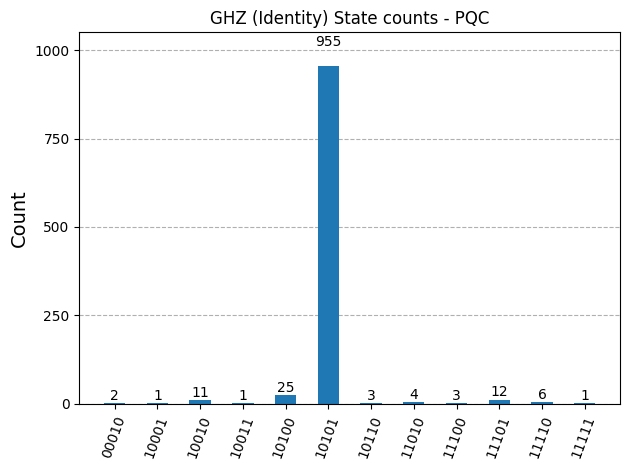

In [14]:
transpiled_circ = transpile(noisy_model_circ_pqc, ideal_sim)
result = ideal_sim.run(transpiled_circ, shots=NUM_SHOTS).result()
counts = result.get_counts(transpiled_circ)

plot_histogram(counts, title='GHZ (Identity) State counts - PQC')

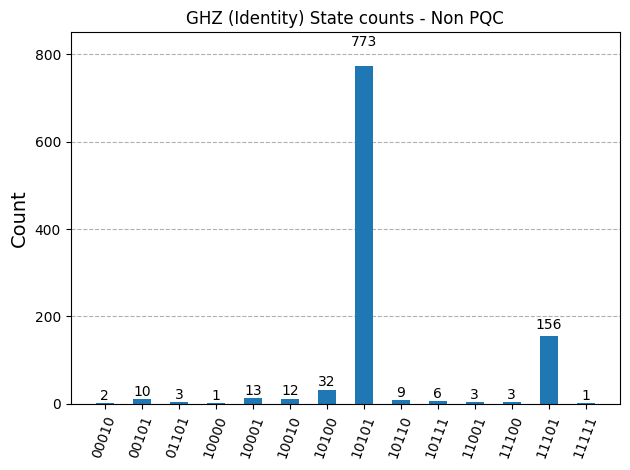

In [15]:
transpiled_circ = transpile(noisy_model_circ.measure_all(inplace=False), ideal_sim)
result = ideal_sim.run(transpiled_circ, shots=NUM_SHOTS).result()
counts = result.get_counts(transpiled_circ)

plot_histogram(counts, title='GHZ (Identity) State counts - Non PQC')

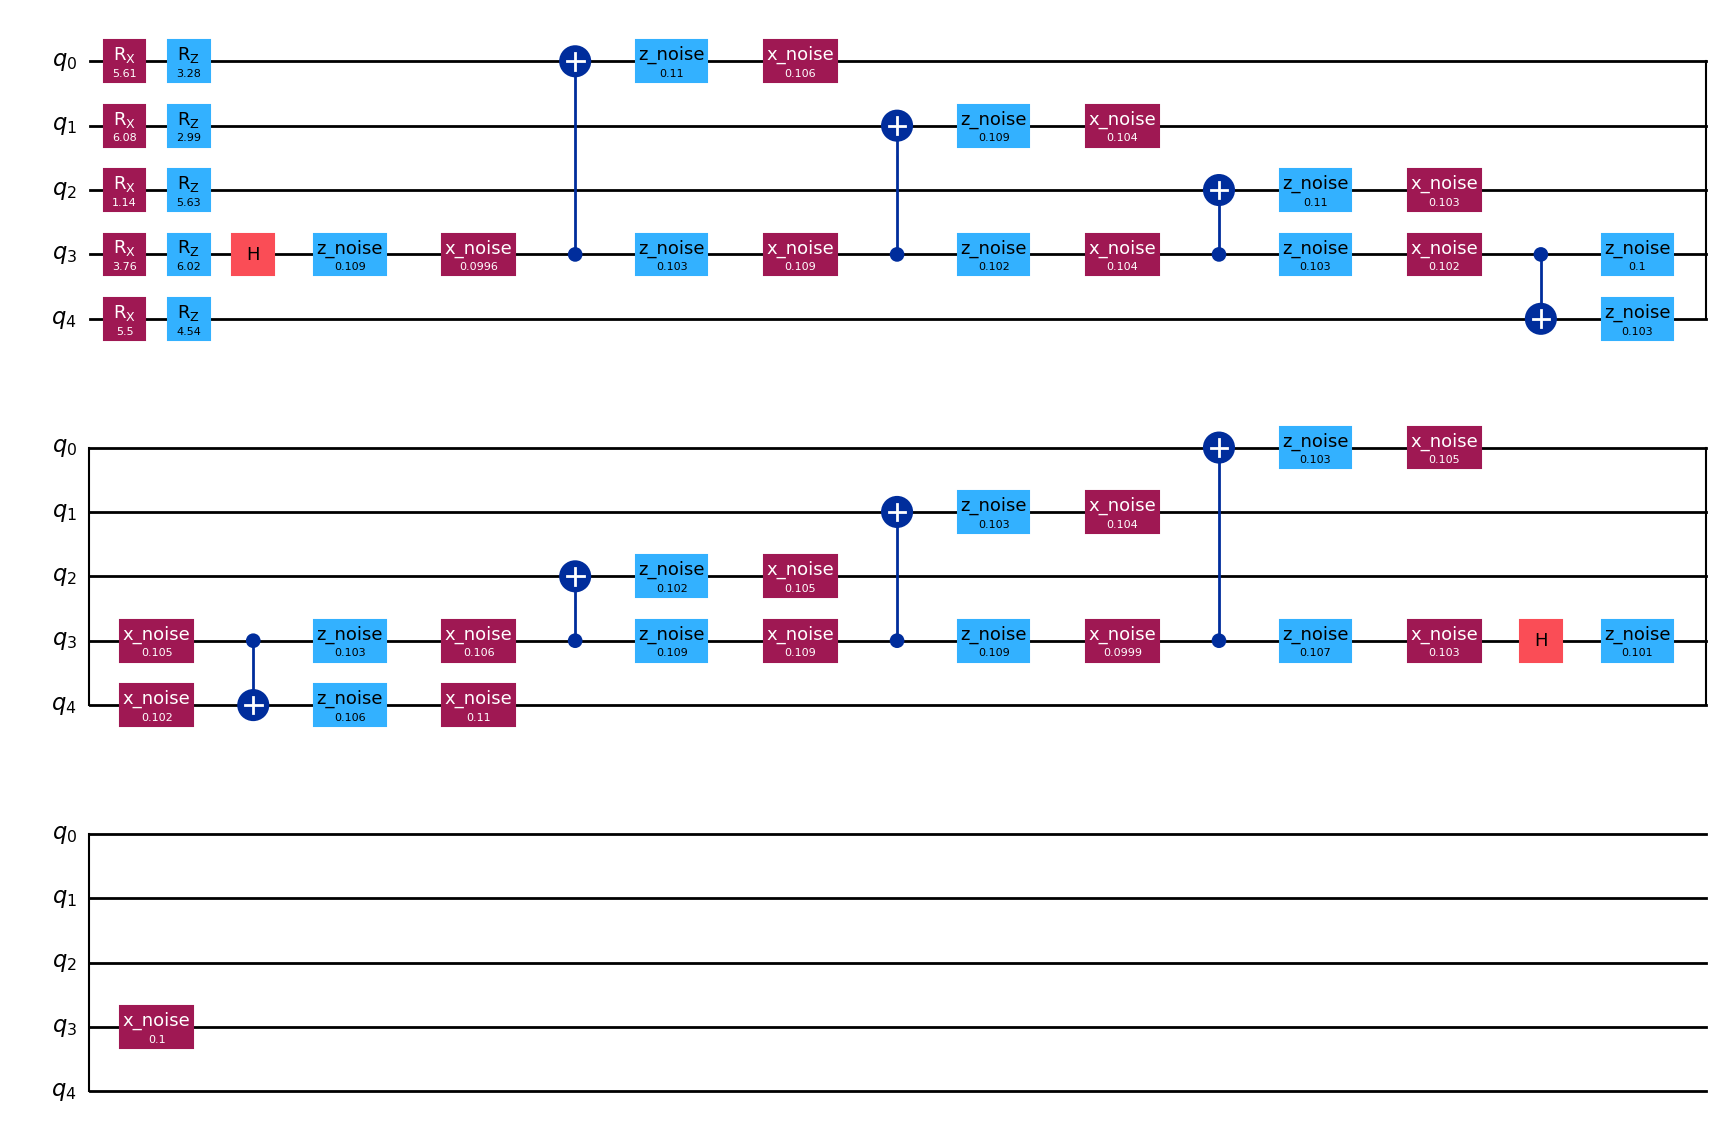

In [16]:
circuit.draw('mpl')

In [17]:
from qiskit.quantum_info import Statevector

def counts_to_probs(counts: torch.Tensor) -> torch.Tensor:
    """Convert integer counts to a normalized probability vector."""
    return counts.float() / counts.sum()

def state_fidelity(psi: torch.Tensor, phi: torch.Tensor) -> torch.Tensor:
    """
    Compute fidelity F = |⟨ψ|φ⟩|² between two normalized state vectors.

    Args:
        psi (torch.Tensor): Complex tensor of shape (2**n,) representing |ψ⟩
        phi (torch.Tensor): Complex tensor of shape (2**n,) representing |φ⟩

    Returns:
        torch.Tensor: Real-valued scalar fidelity
    """
    # Optional: normalize if needed
    psi = psi / torch.linalg.norm(psi)
    phi = phi / torch.linalg.norm(phi)

    overlap = torch.dot(torch.conj(psi), phi)
    return torch.abs(overlap) ** 2

fid_noisy = []
fid_noisy_pqc = []

pqc_params = pqc_model.raw_params

ideal_data_test = get_ideal_data_superpos(NUM_QUBITS, num_vals=20, statevector=True)

for param, ideal in ideal_data_test:
    noisy_circ = ghz_circuit_gen.get_noisy_model_circuit_params(params=param)
    noisy_circ_pqc = append_pqc_to_quantum_circuit(noisy_circ, pqc_params, qiskit_PQC_RZRXRZ_unique)

    # counts_noisy = run_circuit_sampler(noisy_circ.measure_all(inplace=False))
    # counts_noisy_pqc = run_circuit_sampler(noisy_circ_pqc)

    # prob_i = counts_to_probs(ideal)
    # prob_n = counts_to_probs(counts_noisy)
    # prob_ne = counts_to_probs(counts_noisy_pqc)
    noi_out_st = torch.tensor(Statevector.from_instruction(noisy_circ.remove_final_measurements(inplace=False)).data)
    npqc_out_st = torch.tensor(Statevector.from_instruction(noisy_circ_pqc.remove_final_measurements(inplace=False)).data)
    
    

    fid_i_n = state_fidelity(ideal, noi_out_st)
    fid_i_ne = state_fidelity(ideal, npqc_out_st)

    fid_noisy.append(fid_i_n)
    fid_noisy_pqc.append(fid_i_ne)

    

Generating Ideal Data: 100%|██████████| 20/20 [00:00<00:00, 1749.59it/s]


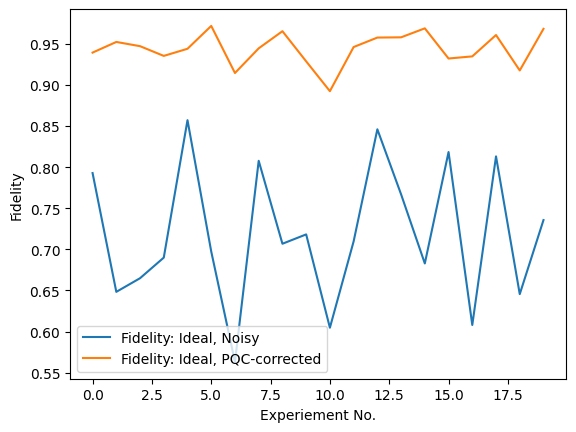

In [18]:
x = range(len(ideal_data_test))

# option 1 ─ two explicit calls
plt.plot(x, fid_noisy,      label='Fidelity: Ideal, Noisy')
plt.plot(x, fid_noisy_pqc,  label='Fidelity: Ideal, PQC-corrected')
plt.xlabel('Experiement No.')          # optional cosmetics
plt.ylabel('Fidelity')
plt.legend()                      # shows the two labels
plt.show()

In [19]:
print(f"Avg Fidelity of noisy circuit: {np.mean(fid_noisy)}, Average Fidelity of noisy circ with PQC: {np.mean(fid_noisy_pqc)}")

Avg Fidelity of noisy circuit: 0.7188936190968087, Average Fidelity of noisy circ with PQC: 0.9440635432151557


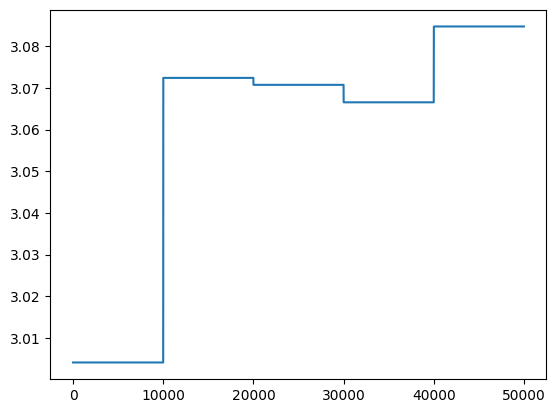

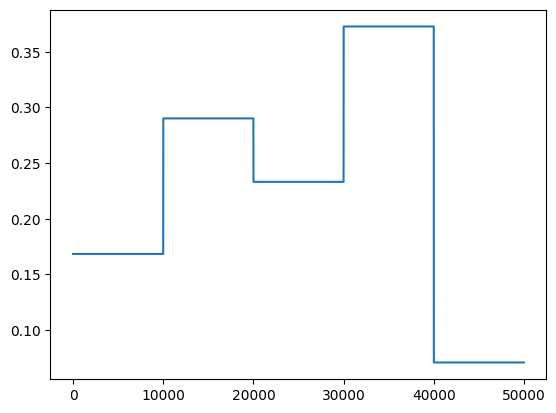

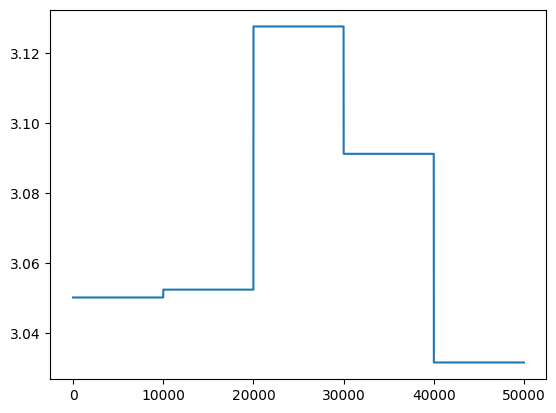

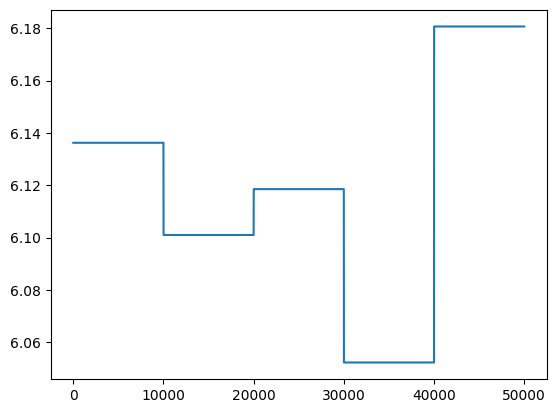

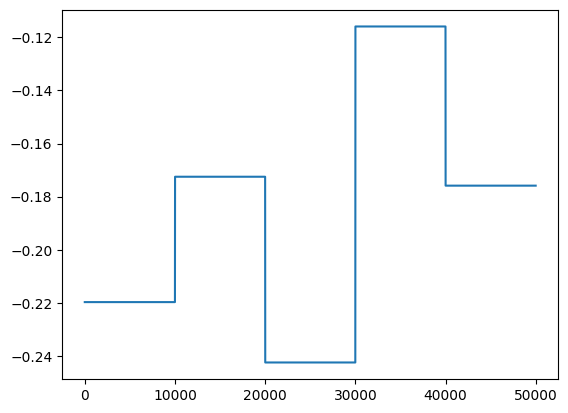

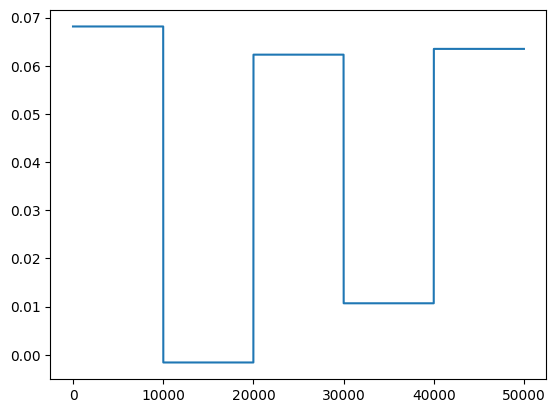

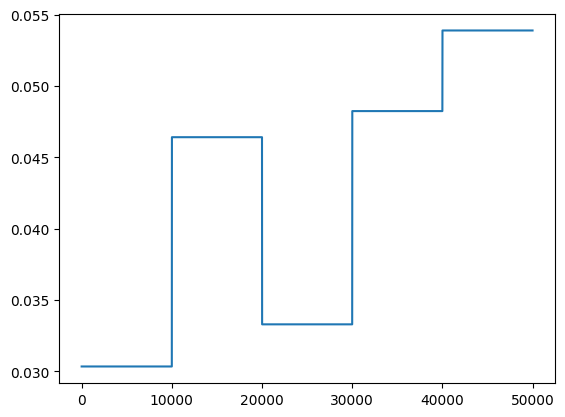

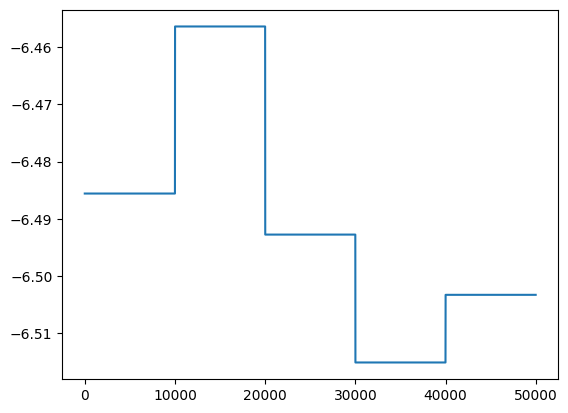

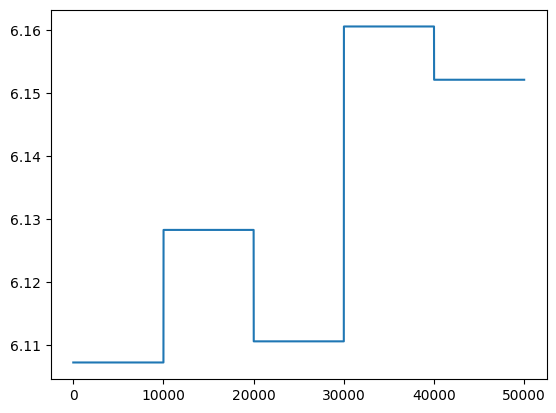

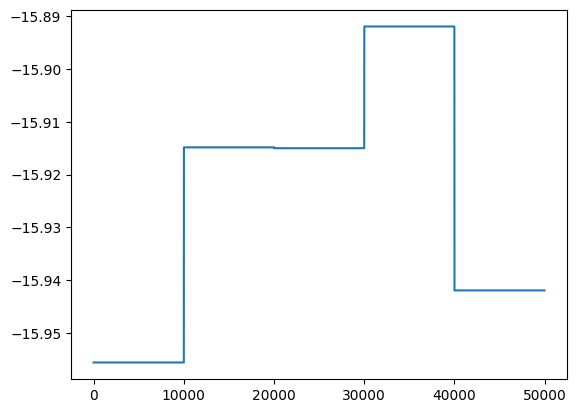

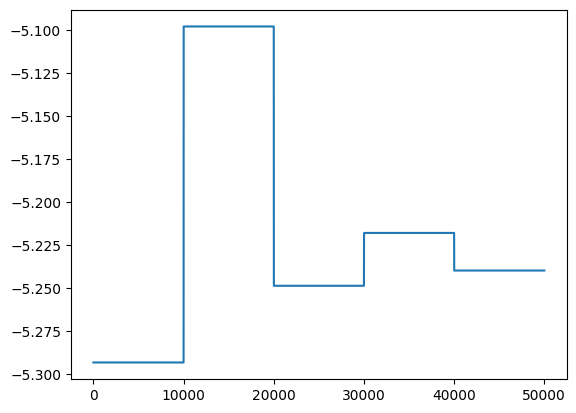

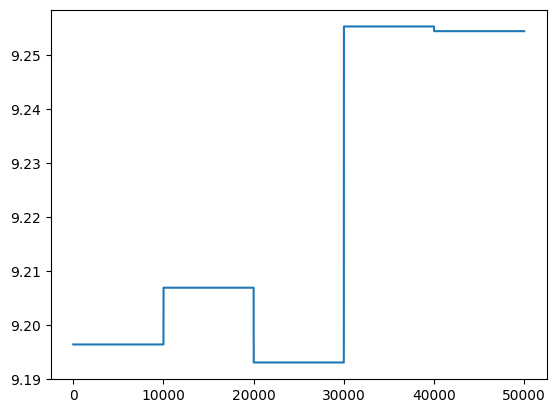

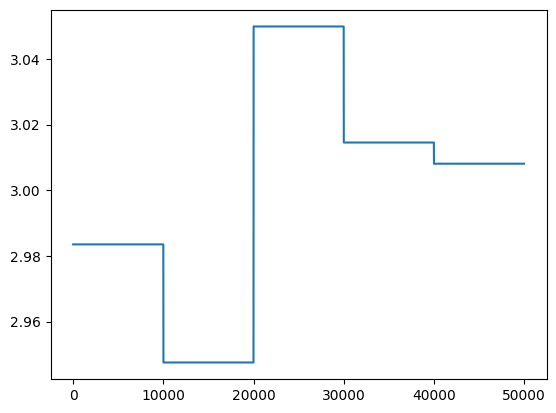

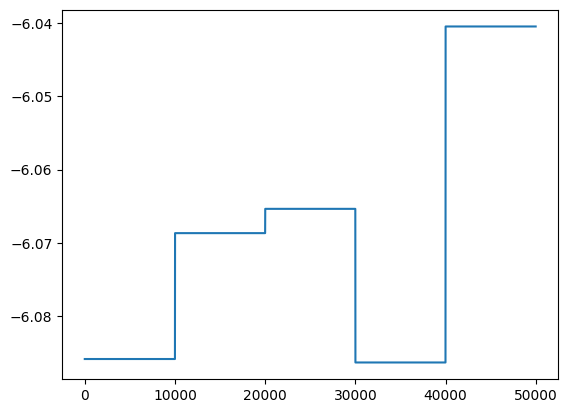

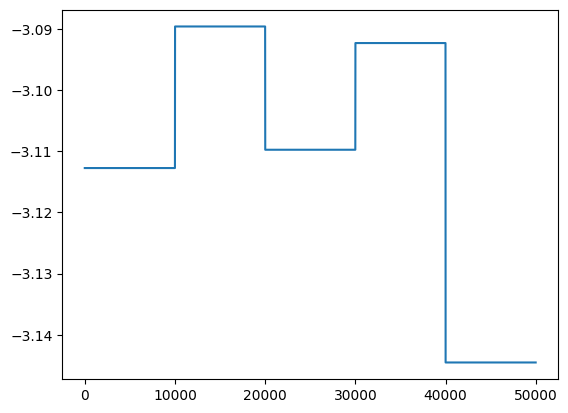

In [20]:
param_arr = np.array(param_list_epoch).transpose()
for pa in param_arr:
    plt.plot(range(len(pa)), pa)
    plt.show()

In [21]:
print(ideal_data[0])

(array([[3.9369   , 2.3587308],
       [1.3379747, 0.4096871],
       [4.832699 , 0.9261413],
       [1.4562938, 5.1695156],
       [2.5560277, 2.6868052]], dtype=float32), tensor([ 0.0428+0.0238j, -0.0086+0.1622j, -0.0249-0.0359j,  0.0707-0.1264j,
        -0.0430+0.0059j, -0.0803-0.1195j,  0.0367+0.0122j,  0.0172+0.1272j,
         0.0307-0.0235j,  0.1149+0.0573j, -0.0339+0.0067j, -0.0694-0.0911j,
        -0.0092+0.0331j, -0.1120+0.0206j,  0.0204-0.0228j,  0.0977+0.0276j,
        -0.0317-0.1122j,  0.2882-0.2579j, -0.0188+0.1022j, -0.3321+0.0929j,
         0.0822+0.0626j, -0.0668+0.3363j, -0.0411-0.0825j,  0.1858-0.2427j,
        -0.0913-0.0124j, -0.0963-0.2903j,  0.0682+0.0458j, -0.0372+0.2701j,
         0.0713-0.0399j,  0.2228+0.1544j, -0.0727+0.0039j, -0.1175-0.2112j],
       dtype=torch.complex128))
